# A Bayesian analysis of the Infection Fatality Rate in Gangelt, and a simple extrapolation to infection-counts in Germany

Matthias Kümmerer, Philipp Berens, Jakob Macke

## Abstract

## Introduction

With the coronavirus pandemic rapidly developing across the world, estimates of key epidemiological quantities are in critical demand. Maybe like never before, their estimates inform policy decisions, possibly affecting the lives of many and impacting economies world wide. For that reason, providing accurate estimates of these quantities, as well as reliable uncertainty intervals around those estimates is paramount. 

Among those key quantities are
the infection rate (IR), i.e. the true fraction of infected people in a population, and  
the infection fatality rate (IFR), i.e. the fraction of people who die after infection (including asymptomatic and
The latter needs to be distinguished from the case fatality rate, which is defined as the fraction of people dying after being diagnosed with Sars-Cov-19. 

A recent study from Germany, the so-called [Heinsberg study](https://www.medrxiv.org/content/10.1101/2020.05.04.20090076v1), aimed at estimating the IR and IFR  in a small town called Gangelt close to Aachen in the west of Germany. This town was hit hard early on in the epidemic due to a super-spreading event caused by Carnival festivities, leading to a (likely) comparably high rate of infected people. While therefore its IR will not be representative for other regions in Germany, it is precisely its high IR which makes it suitable for providing an estimate of the IFR.

The authors combined PCR testing for acute infections and antibody testing, as well as statistical corrections for non-independence among household members and other factors. Among  N=919 participants, they thus estimated an IR of 15.53% (12.31%; 18.96%) (95%CI). Knowing that 7 people with Covid-19-Diagnosis had died in the time frame of the study, they estimated the IFR to be 0.358% (0.293%; 0.451%) (95% CI).
This calculation incorporates uncertainty about the total number of infected people in Gangelt (as the infection count is extrapolated from the tested cases), but not any uncertainty regarding the finite sample of Gangelt as a sample from a larger population.

The authors argue that the observation of 7 deaths in Gangelt is directly observed without error, and therefore does not induce any additional uncertainty. This reasoning could be appropriate if the IFR calculation is exclusively used as a summary statistic describing the data in Gangelt. However, estimates of IFRs are commonly used both in policy-discussions which explicitly or implicitly generalize to regions beyond Gangelt, as well as a means of constraining epidemiological models. Indeed, in the discussion, the authors discuss how their estimated IFR could be used to yield  an estimate of the expected number of infected people in Germany, which they state is at least 1.8 Million people, based on the number of 6757 deaths on May 2nd, 2020. The authors do not provide error bars on this quantity, but rather regard it as a purely theoretical model (for which the error bars on IFR calculated by them would not be valid). 

### Our central questions are:

* How could one provide uncertainty estimates (i.e. error bars) on IFRs in a way that includes both the uncertainty about the IR, as well as the uncertainty arising from the fact that only a finite number of fatalities is observed? 

* How would this uncertainty translate to an uncertainty in the total number of infected people in Germany?  

We show how a Bayesian approach can be used to provide error bars on both the IFR and the number of infected people in Germany, propagating all necessary uncertainties through the inference chain.

We emphasize that we focusely solely on how one could provide uncertainty-estimates on these two quantities with a Bayesian approach -- we do not have the expertise to evaluate the plausibility of the modelling assumptions or the methodology of the study, as discussed below.  



In [3]:
# Setting up necessary packages and environments
%matplotlib inline
import matplotlib.pyplot as plt
import os
os.environ['CXX'] = 'g++'
import pickle
import arviz
import numpy as np
import pandas as pd
import pymc3 as pm
from tqdm import tqdm
from IPython.display import display
import scipy.stats.distributions as dist

ModuleNotFoundError: No module named 'arviz'

In [6]:
def get_quantile(density, bins, q):
    cumsums = np.cumsum(density * (bins[1:] - bins[:-1]))
    
    bin_index = np.nonzero(cumsums>=q)[0][0]
    # report center of bin
    return (bins[bin_index] + bins[bin_index+1]) * 0.5

In [7]:
def beta_a(mean, var):
    assert var < mean*(1-mean)
    
    return mean*(mean*(1-mean)/var-1)

def beta_b(mean, var):
    assert var < mean*(1-mean)
    
    return (1 - mean) * (mean*(1-mean)/var-1)

def beta_params(mean, var):
    return {
        'alpha': beta_a(mean, var),
        'beta': beta_b(mean, var),
    }

# First Model:

We first infer a posterior over the infection fatality rate as follows:
We model the infection rate in gangelt as a beta distribution that captures the uncertainty that the study authors report.
The number of infections in Gangelt is then modelled as binomially distributed depending on the infection rate eand the (fixed) number of people in Gangled.
The number of fatalities is modelled as bionomially distributed depending on the infection fatality rate and the number of infections with a weak beta prior in the infection fatality rate.

After computing the posterior over the infection fatality rate, we model the infections in germany as a negative binomial distribution depending on the infection fatality rate that and the number of deaths in germany.

In [8]:
# todo: beta prior for infection rate (compute with method of moments)
#       beta prior for infection fatality rate (mean=0.1, std>0.1)


# run models with weak priors and with priors that encode what we knew before.
# do sensitivity analysis for priors

# try beta prior over german infected rate and define infected as bernoulli
# compare with sampling negative binomial

# put into private github repo

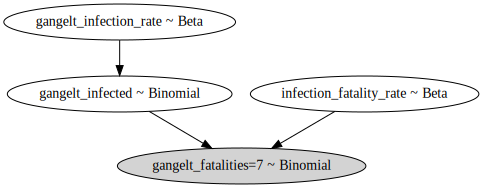

In [9]:
with pm.Model() as model:
    # the infection rate is given as 0.1553 [0.1231, 0.1896].
    gangelt_infection_rate = pm.Beta(**beta_params(mean=0.1553, var=((0.1896-0.1231)/4)**2), name='gangelt_infection_rate')
    
    total_population = 12597
    gangelt_infected = pm.Binomial(n=total_population, p=gangelt_infection_rate, name='gangelt_infected')
    
    infection_fatality_rate = pm.Beta(**beta_params(mean=0.1, var=0.1**2), name='infection_fatality_rate')
    gangelt_fatalities = pm.Binomial(n=gangelt_infected, p=infection_fatality_rate, name='gangelt_fatalities=7', observed=7)    
    display(pm.model_graph.model_to_graphviz(model))

### Inspecting the priors

let's have a look into the priors to see whether they align with our intuitions and are not too narrow

In [10]:
with model:
    prior = pm.sample_prior_predictive(samples=50000)

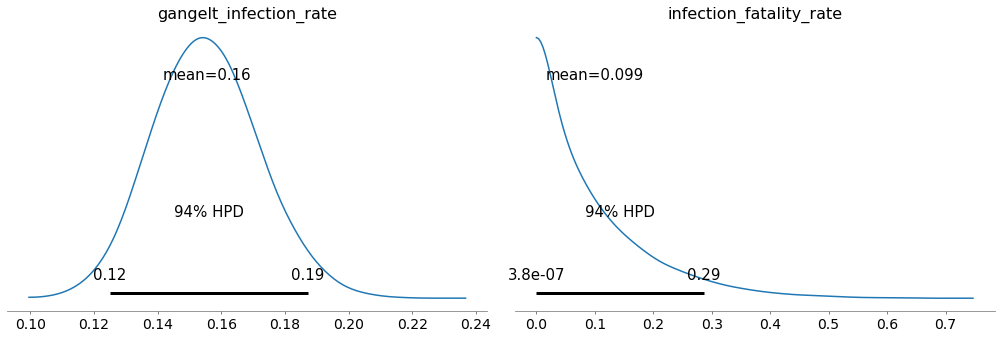

In [11]:
arviz.plot_posterior(prior, var_names=[
    'gangelt_infection_rate',
    'infection_fatality_rate',
]);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f369f03f150>],
      dtype=object)

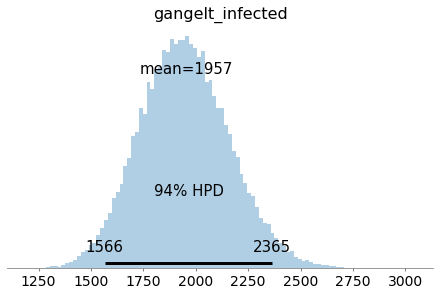

In [12]:
arviz.plot_posterior(prior, var_names=[
    'gangelt_infected',
], bins=100)

## Sampling the posterior

In [13]:
# this allows to continue sampling by executing the next cell repeatedly
posterior = None

In [14]:
with model:
    posterior = pm.sample(draws=1000000, trace=posterior)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [infection_fatality_rate, gangelt_infection_rate]
>Metropolis: [gangelt_infected]
Sampling 4 chains, 0 divergences: 100%|██████████| 4002000/4002000 [25:47<00:00, 2585.74draws/s]
The acceptance probability does not match the target. It is 0.8923484215386331, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8951916587713626, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [15]:
pm.summary(posterior)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
gangelt_infected,1941.735,212.829,1538.000,2337.000,1.435,1.015,21998.0,21998.0,22012.0,47408.0,1.0
gangelt_infection_rate,0.154,0.017,0.123,0.186,0.000,0.000,22549.0,22549.0,22565.0,49823.0,1.0
infection_fatality_rate,0.004,0.002,0.001,0.007,0.000,0.000,221182.0,221182.0,224374.0,558405.0,1.0


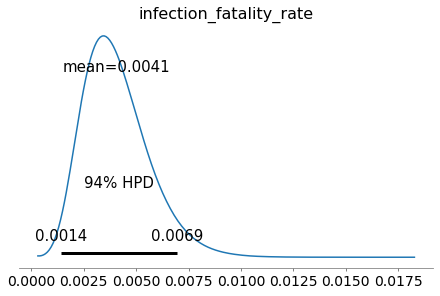

In [16]:
arviz.plot_posterior(posterior, var_names=[
    'infection_fatality_rate'
], bins=100);

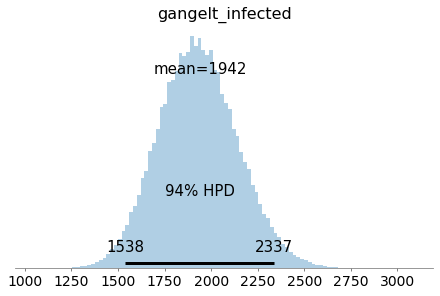

In [17]:
arviz.plot_posterior(posterior, var_names=[
    'gangelt_infected'
], bins=100);

## Sampling the number of infections in Germany with a negative binomial distribution

In [18]:
german_infected = [dist.nbinom(n=6575, p=p).rvs() for p in tqdm(posterior['infection_fatality_rate'])]

100%|██████████| 4000000/4000000 [47:02<00:00, 1417.35it/s] 


(500000.0, 5000000.0)

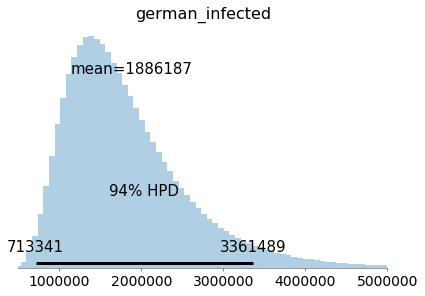

In [19]:
#arviz.plot_posterior(np.array(german_infected), bins=300, );
arviz.plot_posterior({"german_infected": german_infected}, bins=300, );
plt.xlim(5e5, 5e6)

# Checking different priors

Here we test how much the prior over the IFR matters for the results.

### Wider prior in IFR

In this model we still use a beta prior over the IFR, but with mean 0.1 and std 0.2 (instead of 0.1). So this pior is less informed.

In [20]:
with pm.Model() as model_1:
    # the infection rate is given as 0.1553 [0.1231, 0.1896].
    gangelt_infection_rate = pm.Beta(**beta_params(mean=0.1553, var=((0.1896-0.1231)/4)**2), name='gangelt_infection_rate')
    
    total_population = 12597
    gangelt_infected = pm.Binomial(n=total_population, p=gangelt_infection_rate, name='gangelt_infected')
    
    infection_fatality_rate = pm.Beta(**beta_params(mean=0.1, var=0.2**2), name='infection_fatality_rate')
    gangelt_fatalities = pm.Binomial(n=gangelt_infected, p=infection_fatality_rate, name='gangelt_fatalities=7', observed=7)    

with model_1:
    prior_1 = pm.sample_prior_predictive(samples=50000)

with model_1:
    posterior_1 = pm.sample(draws=1000000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [infection_fatality_rate, gangelt_infection_rate]
>Metropolis: [gangelt_infected]
Sampling 4 chains, 333 divergences: 100%|██████████| 4002000/4002000 [22:12<00:00, 3003.98draws/s]
There were 333 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4792929416161449, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6273868608727342, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


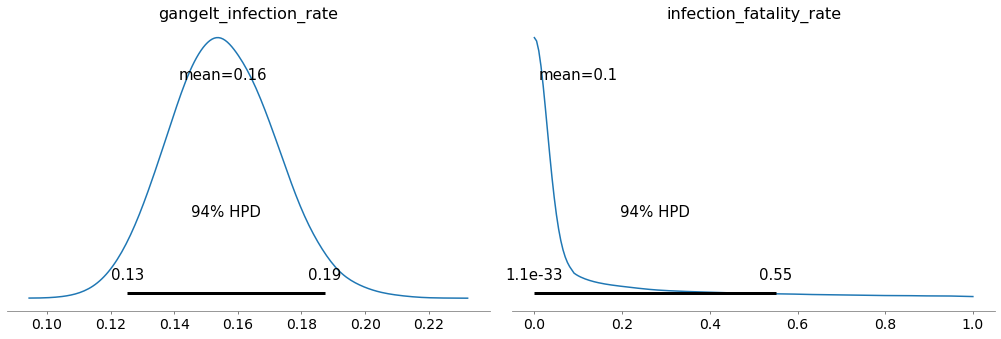

In [21]:
arviz.plot_posterior(prior_1, var_names=[
    'gangelt_infection_rate',
    'infection_fatality_rate',
]);

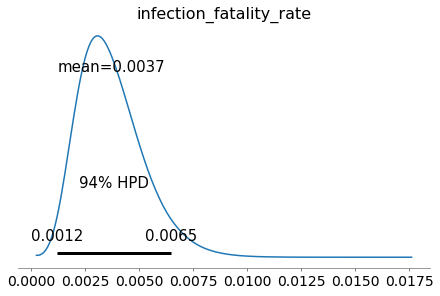

In [22]:
arviz.plot_posterior(posterior_1, var_names=[
    'infection_fatality_rate'
], bins=100);

In [23]:
german_infected_1 = [dist.nbinom(n=6575, p=p).rvs() for p in (posterior_1['infection_fatality_rate'])]

(500000.0, 5000000.0)

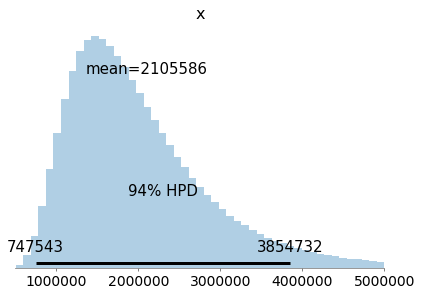

In [24]:
arviz.plot_posterior(np.array(german_infected_1), bins=300);
plt.xlim(5e5, 5e6)

### Uniform  prior in IFR

In [25]:
with pm.Model() as model_2:
    # the infection rate is given as 0.1553 [0.1231, 0.1896].
    gangelt_infection_rate = pm.Beta(**beta_params(mean=0.1553, var=((0.1896-0.1231)/4)**2), name='gangelt_infection_rate')
    
    total_population = 12597
    gangelt_infected = pm.Binomial(n=total_population, p=gangelt_infection_rate, name='gangelt_infected')
    
    infection_fatality_rate = pm.Uniform(lower=0,upper=1, name='infection_fatality_rate')
    gangelt_fatalities = pm.Binomial(n=gangelt_infected, p=infection_fatality_rate, name='gangelt_fatalities=7', observed=7)    

    prior_2 = pm.sample_prior_predictive(samples=50000)

    posterior_2 = pm.sample(draws=1000000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [infection_fatality_rate, gangelt_infection_rate]
>Metropolis: [gangelt_infected]
Sampling 4 chains, 15,605 divergences: 100%|██████████| 4002000/4002000 [22:07<00:00, 3015.26draws/s]
There were 15339 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2898463808559525, but should be close to 0.8. Try to increase the number of tuning steps.
There were 266 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4873397051290166, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7170947687250149, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


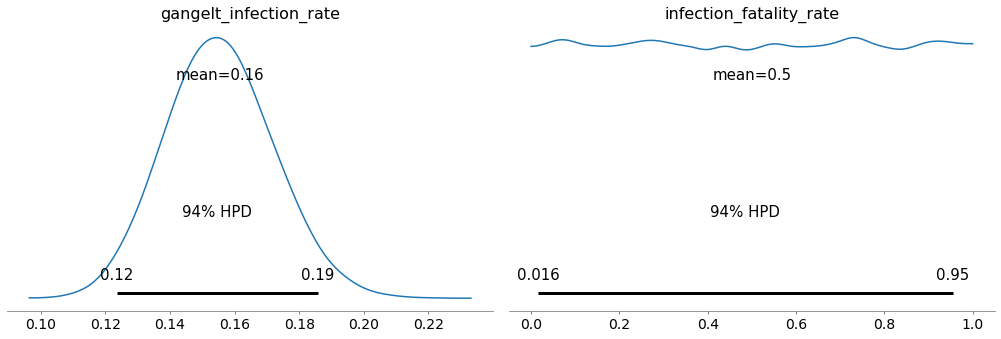

In [26]:
arviz.plot_posterior(prior_2, var_names=[
    'gangelt_infection_rate',
    'infection_fatality_rate',
]);

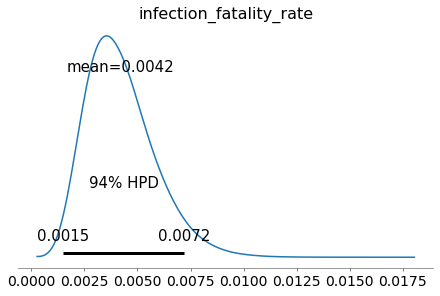

In [27]:
arviz.plot_posterior(posterior_2, var_names=[
    'infection_fatality_rate'
], bins=100);

In [28]:
german_infected_2 = [dist.nbinom(n=6575, p=p).rvs() for p in (posterior_2['infection_fatality_rate'])]

(500000.0, 5000000.0)

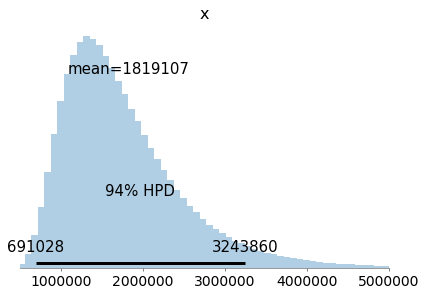

In [29]:
arviz.plot_posterior(np.array(german_infected_2), bins=300);
plt.xlim(5e5, 5e6)

Text(0.01, 0.25, 'Posterior')

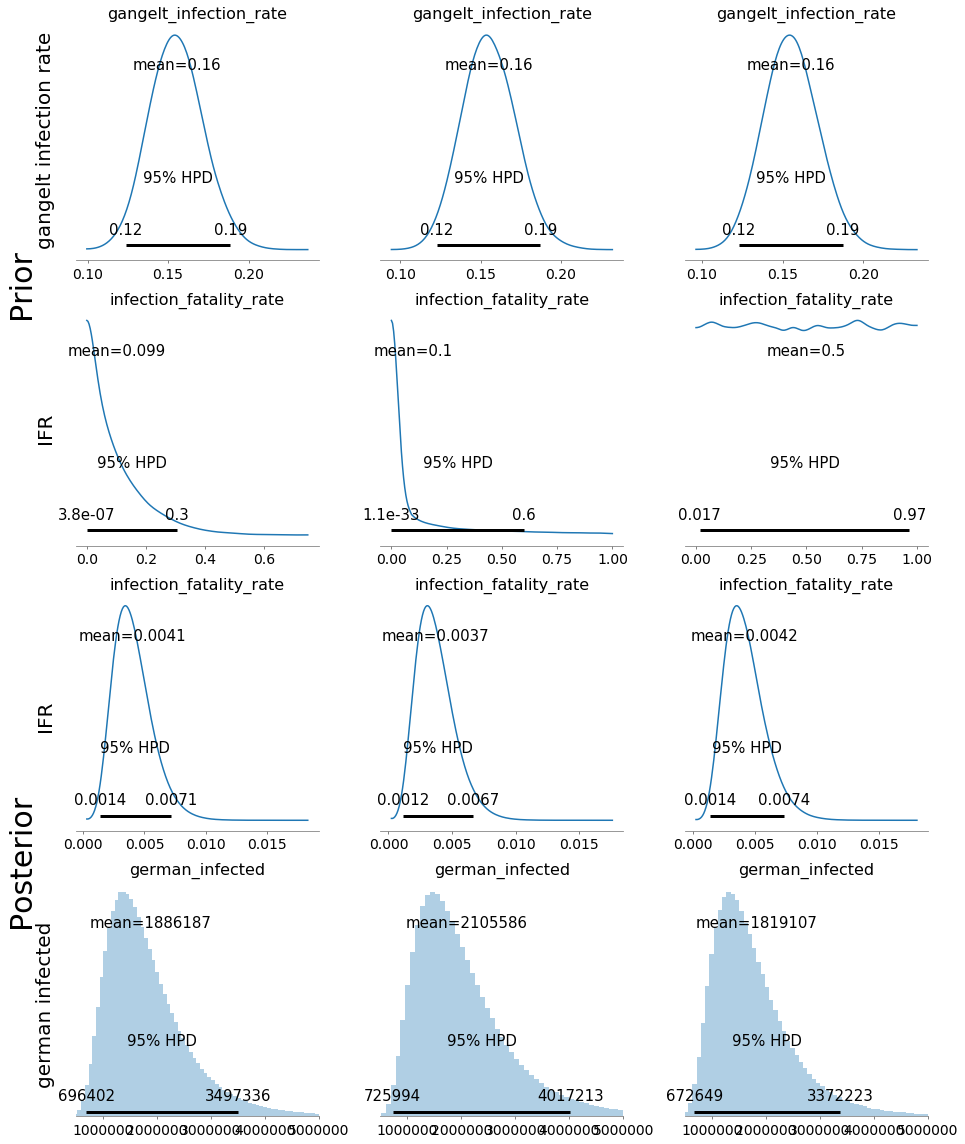

In [61]:
rows = 4
cols = 3
width = 4.5
height = 4

f, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*height))

models = [
    (prior, posterior, german_infected),
    (prior_1, posterior_1, german_infected_1),
    (prior_2, posterior_2, german_infected_2),
    #(prior_3, posterior_3, german_infected_3),
]

for model_index, (_prior, _posterior, _german_infected) in enumerate(models):

    arviz.plot_posterior(_prior, var_names=[
        'gangelt_infection_rate',
        #'infection_fatality_rate',
            ], credible_interval=0.95, ax=axs[0, model_index],
        #textsize=0.01,
    );
    
    arviz.plot_posterior(_prior, var_names=[
        #'gangelt_infection_rate',
        'infection_fatality_rate',
    ], credible_interval=0.95, ax=axs[1, model_index]);

    arviz.plot_posterior(_posterior, var_names=[
        'infection_fatality_rate',
    ], credible_interval=0.95, ax=axs[2, model_index]);
    
    arviz.plot_posterior({"german_infected": _german_infected}, bins=300, ax=axs[3, model_index], credible_interval=0.95);
    axs[3, model_index].set_xlim(5e5, 5e6)

plt.tight_layout(rect=(0.05, 0, 1, 1))
plt.gcf().text(0.04, 3.5/rows, 'gangelt infection rate', rotation=90, verticalalignment='center', fontsize=20)
plt.gcf().text(0.04, 2.5/rows, 'IFR', rotation=90, verticalalignment='center', fontsize=20)
plt.gcf().text(0.04, 1.5/rows, 'IFR', rotation=90, verticalalignment='center', fontsize=20)
plt.gcf().text(0.04, 0.5/rows, 'german infected', rotation=90, verticalalignment='center', fontsize=20)
plt.gcf().text(0.01, 3/rows, 'Prior', rotation=90, verticalalignment='center', fontsize=30)
plt.gcf().text(0.01, 1/rows, 'Posterior', rotation=90, verticalalignment='center', fontsize=30)


# Normal instead of Beta prior for infection rate

The Heinsberg study estimates the infection rate in gangelt to be 0.1553 [0.1231, 0.1896]. So far we modeled this as a Beta distribution, which is a natural choice for a distribution over probabilities. However, people from outside Bayesian statistics might have used a normal prior with same mean and variance. Here we check whether this influences results.

In [30]:
with pm.Model() as model_3:
    # the infection rate is given as 0.1553 [0.1231, 0.1896].
    gangelt_infection_rate = pm.Normal(mu=0.1553, sd=(0.1896-0.1231)/4, name='gangelt_infection_rate')
    
    
    total_population = 12597
    gangelt_infected = pm.Binomial(n=total_population, p=gangelt_infection_rate, name='gangelt_infected')
    
    infection_fatality_rate = pm.Beta(**beta_params(mean=0.1, var=0.1**2), name='infection_fatality_rate')
    gangelt_fatalities = pm.Binomial(n=gangelt_infected, p=infection_fatality_rate, name='gangelt_fatalities=7', observed=7)    

    prior_3 = pm.sample_prior_predictive(samples=50000)

    posterior_3 = pm.sample(draws=1000000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [infection_fatality_rate, gangelt_infection_rate]
>Metropolis: [gangelt_infected]
Sampling 4 chains, 0 divergences: 100%|██████████| 4002000/4002000 [21:32<00:00, 3097.14draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [31]:
german_infected_3 = [dist.nbinom(n=6575, p=p).rvs() for p in tqdm(posterior_3['infection_fatality_rate'])]

100%|██████████| 4000000/4000000 [46:41<00:00, 1427.80it/s] 


Text(0.01, 0.25, 'Posterior')

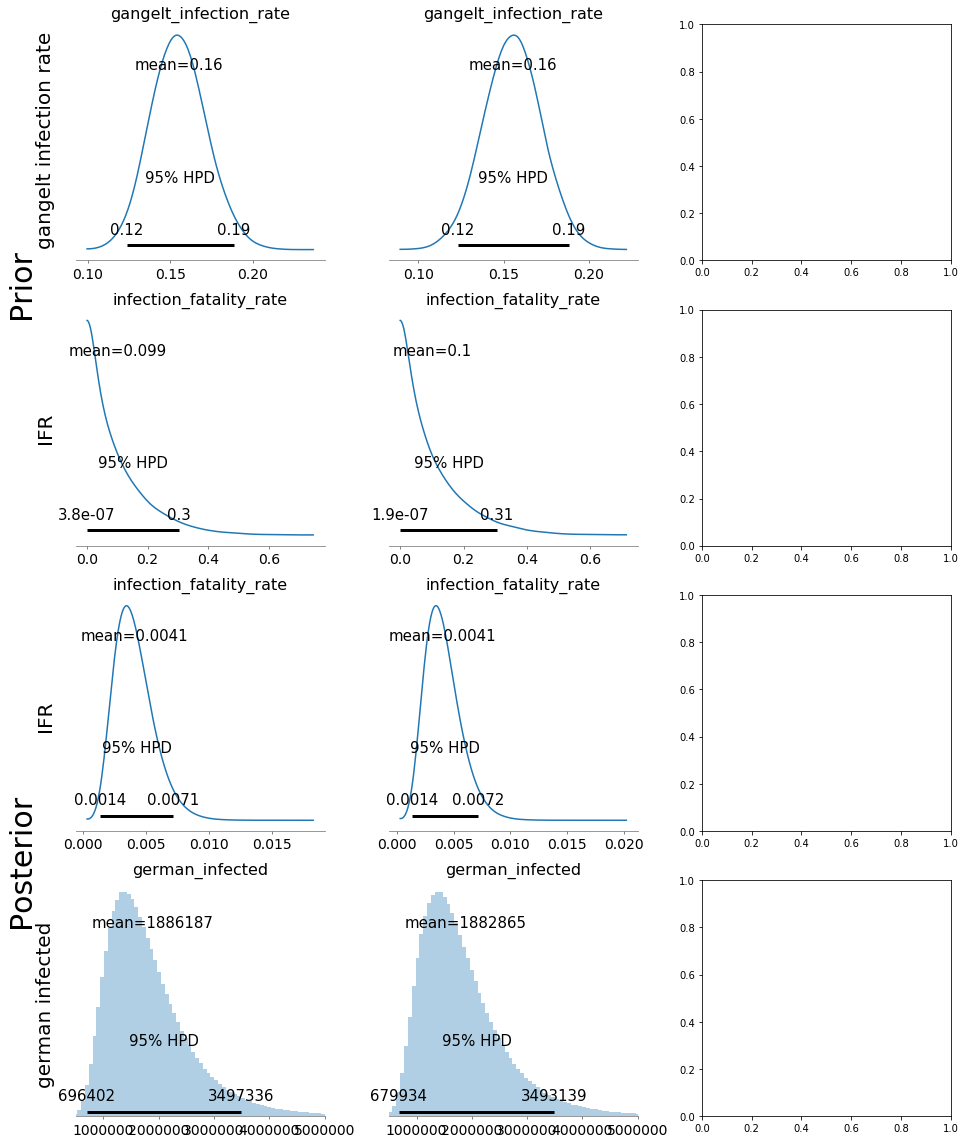

In [62]:
rows = 4
cols = 2
width = 4.5
height = 4

f, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*height))

models = [
    (prior, posterior, german_infected),
    #(prior_1, posterior_1, german_infected_1),
    #(prior_2, posterior_2, german_infected_2),
    (prior_3, posterior_3, german_infected_3),
]

for model_index, (_prior, _posterior, _german_infected) in enumerate(models):

    arviz.plot_posterior(_prior, var_names=[
        'gangelt_infection_rate',
        #'infection_fatality_rate',
            ], credible_interval=0.95, ax=axs[0, model_index],
        #textsize=0.01,
    );
    
    arviz.plot_posterior(_prior, var_names=[
        #'gangelt_infection_rate',
        'infection_fatality_rate',
    ], credible_interval=0.95, ax=axs[1, model_index]);

    arviz.plot_posterior(_posterior, var_names=[
        'infection_fatality_rate',
    ], credible_interval=0.95, ax=axs[2, model_index]);
    
    arviz.plot_posterior({"german_infected": _german_infected}, bins=300, ax=axs[3, model_index], credible_interval=0.95);
    axs[3, model_index].set_xlim(5e5, 5e6)

plt.tight_layout(rect=(0.05, 0, 1, 1))
plt.gcf().text(0.04, 3.5/rows, 'gangelt infection rate', rotation=90, verticalalignment='center', fontsize=20)
plt.gcf().text(0.04, 2.5/rows, 'IFR', rotation=90, verticalalignment='center', fontsize=20)
plt.gcf().text(0.04, 1.5/rows, 'IFR', rotation=90, verticalalignment='center', fontsize=20)
plt.gcf().text(0.04, 0.5/rows, 'german infected', rotation=90, verticalalignment='center', fontsize=20)
plt.gcf().text(0.01, 3/rows, 'Prior', rotation=90, verticalalignment='center', fontsize=30)
plt.gcf().text(0.01, 1/rows, 'Posterior', rotation=90, verticalalignment='center', fontsize=30)


# Different numbers of fatalities

So far we used a number of seven fatalities in Gangelt, as in the results of the study. However, the paper reports that at least one additional death occured at the very end of the study, other sources even speak of nine deaths. Here we run the model with different numbers of fatalities in Gangelt and see how much this influences results.

In [63]:
fatality_models = {}

In [65]:
# Run the model for different numbers of fatalities
for fatalities in [5, 6, 7, 8, 9]:
    print(fatalities)
    if fatalities in fatality_models:
        continue
    with pm.Model() as model:
        # the infection rate is given as 0.1553 [0.1231, 0.1896].
        gangelt_infection_rate = pm.Beta(**beta_params(mean=0.1553, var=((0.1896-0.1231)/4)**2), name='gangelt_infection_rate')

        total_population = 12597
        gangelt_infected = pm.Binomial(n=total_population, p=gangelt_infection_rate, name='gangelt_infected')

        infection_fatality_rate = pm.Beta(**beta_params(mean=0.1, var=0.1**2), name='infection_fatality_rate')
        gangelt_fatalities = pm.Binomial(n=gangelt_infected, p=infection_fatality_rate, name='gangelt_fatalities', observed=fatalities)
    
        _prior = pm.sample_prior_predictive(samples=50000)
        _posterior = pm.sample(draws=100000)
        
    _german_infected = [dist.nbinom(n=6575, p=p).rvs() for p in tqdm(_posterior['infection_fatality_rate'])]
    fatality_models[fatalities] = {
        'model': model,
        'prior': _prior,
        'posterior': _posterior,
        'german_infected': _german_infected
    }

5
6
7
8
9


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [infection_fatality_rate, gangelt_infection_rate]
>Metropolis: [gangelt_infected]
Sampling 4 chains, 86 divergences: 100%|██████████| 402000/402000 [02:47<00:00, 2394.48draws/s]
The acceptance probability does not match the target. It is 0.6744761170350584, but should be close to 0.8. Try to increase the number of tuning steps.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4525755647825932, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
100%|██████████| 400000/400000 [05:32<00:00, 1201.60it/s]


In [66]:
with open('model1_fatality_analysis.pydata', 'wb') as f:
    pickle.dump(fatality_models, f)

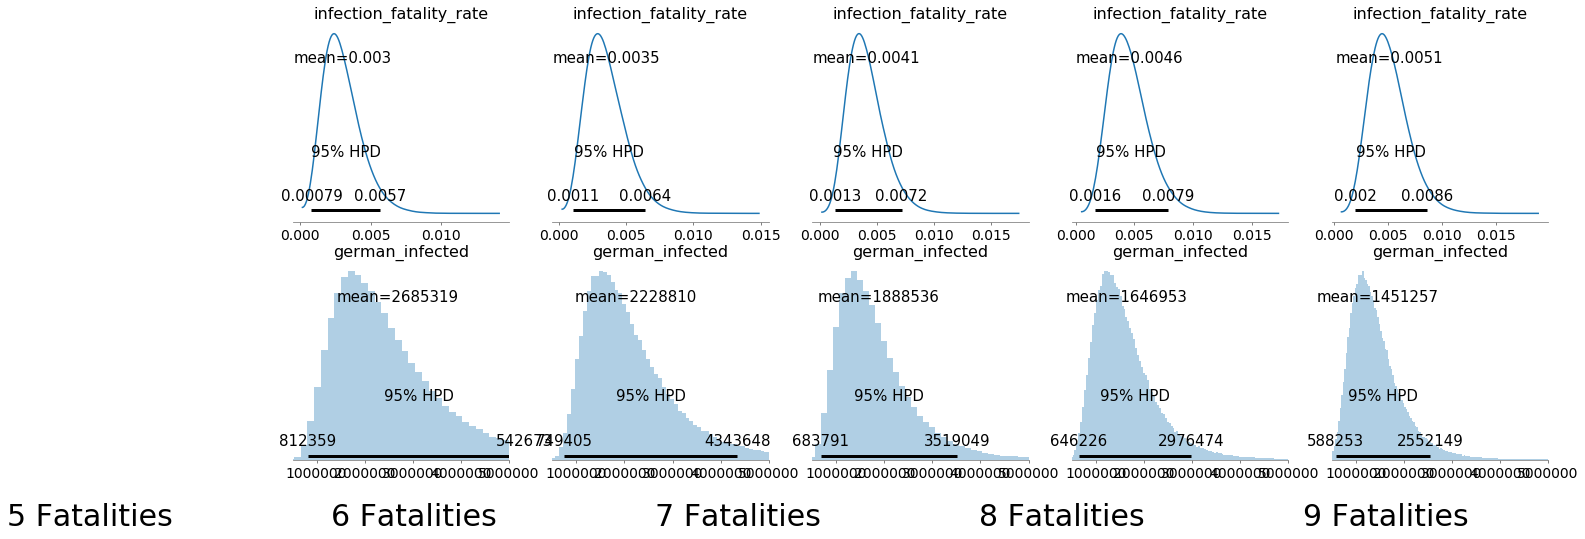

In [68]:
rows = 2
cols = 5
width = 4.5
height = 4

f, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*height))

for model_index, (fatalities, data) in enumerate(fatality_models.items()):
    
    arviz.plot_posterior(data['posterior'], var_names=[
        'infection_fatality_rate',
    ], credible_interval=0.95, ax=axs[0, model_index]);
    
    arviz.plot_posterior({"german_infected": data['german_infected']}, bins=300, ax=axs[1, model_index], credible_interval=0.95);
    axs[1, model_index].set_xlim(5e5, 5e6)
    
    plt.gcf().text(model_index/cols, 0.01, f'{fatalities} Fatalities', horizontalalignment='center', fontsize=30)

# plt.tight_layout(rect=(0.05, 0, 1, 1))
# plt.gcf().text(0.04, 3.5/rows, 'gangelt infection rate', rotation=90, verticalalignment='center', fontsize=20)
# plt.gcf().text(0.04, 2.5/rows, 'IFR', rotation=90, verticalalignment='center', fontsize=20)
# plt.gcf().text(0.04, 1.5/rows, 'IFR', rotation=90, verticalalignment='center', fontsize=20)
# plt.gcf().text(0.04, 0.5/rows, 'german infected', rotation=90, verticalalignment='center', fontsize=20)
# plt.gcf().text(0.01, 3/rows, 'Prior', rotation=90, verticalalignment='center', fontsize=30)
# plt.gcf().text(0.01, 1/rows, 'Posterior', rotation=90, verticalalignment='center', fontsize=30)

